<a href="https://colab.research.google.com/github/zihxnw/Data-Bootcamp-Final-Project/blob/main/Zihan_%26_Aleesha_Visualizations_(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install meteostat

In [ ]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from meteostat import Daily
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/forest fires/FPA_FOD_20221014.sqlite'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conn = sqlite3.connect(path)
query = """
    SELECT FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_TIME, LATITUDE, LONGITUDE, NWCG_GENERAL_CAUSE, STATE, FIRE_SIZE, FIRE_SIZE_CLASS
    FROM Fires
    """
df = pd.read_sql_query(query, conn)
conn.close()

In [ ]:
def get_region(row):
    state = row['STATE']
    #defining regions
    regionmap = {
        'CA': 'West',
        'OR': 'Northwest', 'WA': 'Northwest',
        'AZ': 'Southwest', 'NM': 'Southwest', 'TX': 'Southwest', 'OK': 'Southwest',
        'CO': 'Rockies', 'ID': 'Rockies', 'MT': 'Rockies',
        'WY': 'Rockies', 'UT': 'Rockies', 'NV': 'Rockies',
        'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
        'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest',
        'IL': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 'OH': 'Midwest',
        'KY': 'Southeast', 'WV': 'Southeast', 'VA': 'Southeast', 'TN': 'Southeast',
        'NC': 'Southeast', 'SC': 'Southeast', 'GA': 'Southeast', 'AL': 'Southeast',
        'MS': 'Southeast', 'AR': 'Southeast', 'LA': 'Southeast', 'FL': 'Southeast',
        'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast',
        'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast',
        'PA': 'Northeast', 'DE': 'Northeast', 'MD': 'Northeast', 'DC': 'Northeast'
    }
    return regionmap.get(state)

df['Region'] = df.apply(get_region, axis=1)

print(df['Region'].value_counts())

Region
Southeast    852292
Southwest    378810
West         251881
Rockies      239850
Midwest      236276
Northeast    184865
Northwest    112225
Name: count, dtype: int64


In [ ]:
station_map = {
    'West': '72483',
    'Southwest': '72278',
    'Northwest': '72698',
    'Rockies': '72469',
    'Midwest': '72530',
    'Southeast': '72219',
    'Northeast': '72503'
}

weather = []
#used airport codes to find weather for each region.
for region, station_id in station_map.items():
    data = Daily(station_id, start=datetime(1992, 1, 1), end=datetime(2020, 12, 31))
    data = data.fetch()
    weatherdf = data.reset_index()
    weatherdf['time'] = pd.to_datetime(weatherdf['time']).dt.normalize()
    weatherdf = weatherdf.rename(columns={'time': 'DISCOVERY_DATE'})
    weatherdf['Region'] = region
    weather.append(weatherdf[['DISCOVERY_DATE', 'Region', 'tmax', 'wspd']])
dfweather = pd.concat(weather)
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.normalize()
#merging dataframes together
df = df.merge(dfweather, on=['Region', 'DISCOVERY_DATE'], how='left')
(df[['DISCOVERY_DATE', 'Region', 'tmax', 'wspd']].head())

,DISCOVERY_DATE,Region,tmax,wspd
0,2005-02-02,West,16.1,4.7
1,2004-05-12,West,27.2,14.4
2,2004-05-31,West,33.9,6.1
3,2004-06-28,West,31.7,14.4
4,2004-06-28,West,31.7,14.4


In [ ]:
threshold = 10
df["DISCOVERY_DATE"] = pd.to_datetime(df["DISCOVERY_DATE"])
df["Month"] = df["DISCOVERY_DATE"].dt.month
df["is_severe"] = (df["FIRE_SIZE"] > threshold).astype(int)
df['DOW'] = df['DISCOVERY_DATE'].dt.dayofweek
df['DOY'] = df['DISCOVERY_DATE'].dt.dayofyear
df['Cause_Code'] = df['NWCG_GENERAL_CAUSE'].astype('category').cat.codes #assigned alphabetically!
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "FIRE_SIZE", "Month", "NWCG_GENERAL_CAUSE", 'tmax', 'wspd'])
df = df[df['NWCG_GENERAL_CAUSE'] != "Missing data/not specified/undetermined"]
#fire index is just combining temperature & wind speed
df['Fire_Index'] = df['tmax'] * df['wspd']

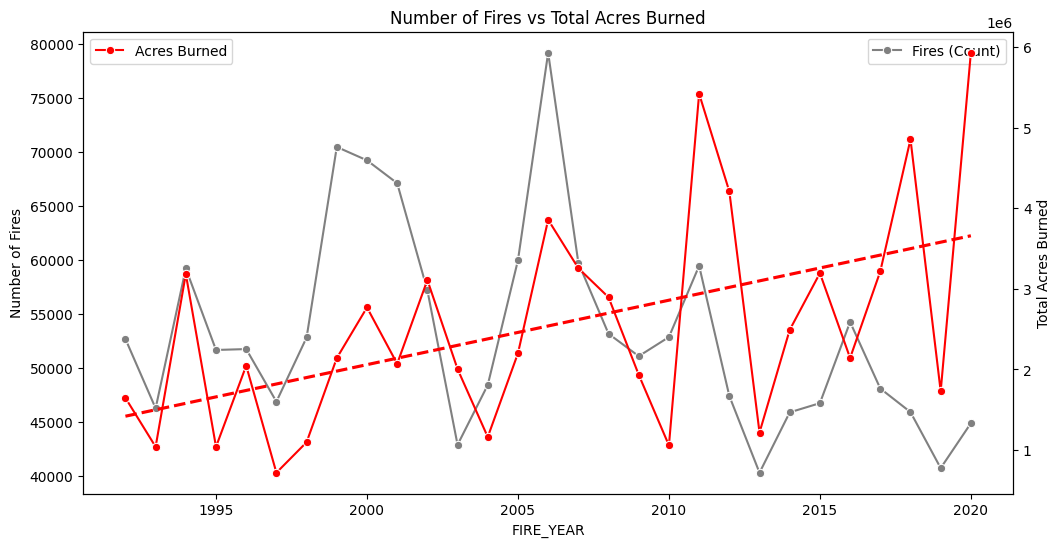

In [ ]:
yearly = df.groupby('FIRE_YEAR')['FIRE_SIZE'].agg(['sum', 'count']).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.lineplot(data=yearly, x='FIRE_YEAR', y='count', ax=ax1, color='grey', marker='o', label='Fires (Count)')

sns.lineplot(data=yearly, x='FIRE_YEAR', y='sum', ax=ax2, color='red', marker='o', label='Acres Burned')
sns.regplot(data=yearly, x='FIRE_YEAR', y='sum', ax=ax2, scatter=False, color='red', line_kws={'linestyle':'--'}, ci= None)

ax1.set_title('Number of Fires vs Total Acres Burned')
ax1.set_ylabel("Number of Fires")
ax2.set_ylabel("Total Acres Burned")
plt.show()

In [ ]:
#balancing out the regions by making each region have the same amount of entries (# of entries of the region with the least!)
min_size = df['Region'].value_counts().min()
df = df.groupby('Region').apply(
    lambda x: x.sample(min_size, random_state=50)
).reset_index(drop=True)
print(df['Region'].value_counts())

Region
Midwest      34531
Northeast    34531
Northwest    34531
Rockies      34531
Southeast    34531
Southwest    34531
West         34531
Name: count, dtype: int64


In [ ]:
mapdf = df[["LATITUDE", 'LONGITUDE']]
sample_size = 150000
dfmap = mapdf.sample(n=sample_size, random_state=50)
map = folium.Map(location=[40.729675, -73.996925], zoom_start=4)

map = folium.Map(
    location=[40.729675, -73.996925],
    zoom_start=4,
    tiles='OpenStreetMap'
)

heatmap = dfmap[['LATITUDE', 'LONGITUDE']].values.tolist()

HeatMap(
    heatmap,
    radius=11,
    blur=15,
    min_opacity=0.4,
    gradient={0.2: 'blue', 0.4: 'green', 0.6: 'orange', 1: 'red'}
).add_to(map)

map

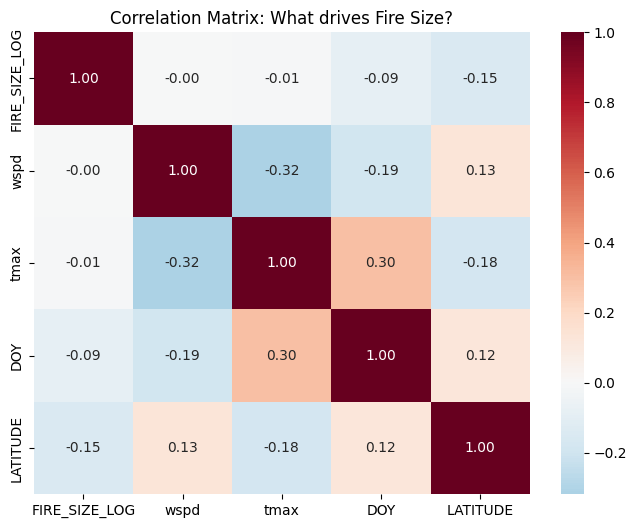

In [ ]:
df_new = df.dropna(subset=["tmax", "wspd", "FIRE_SIZE"])
df_new["FIRE_SIZE_LOG"] = np.log1p(df_new["FIRE_SIZE"])

cols = ["FIRE_SIZE_LOG", "wspd", "tmax", "DOY", "LATITUDE"]
corr = df_new[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,
            annot=True,
            cmap="RdBu_r",
            center=0,
            fmt=".2f")
plt.title("Correlation Matrix: What drives Fire Size?")
plt.show()